# Pirámides por sectores del mapa

Este notebook usa la misma fuente que `parroquiasDesglose.ipynb` (`data/parroquiasDesglose.xlsx`) y rehace los gráficos comparativos para:
- `VALLES` vs cada otro sector del mapa (6 gráficos)
- `UDLA` vs cada otro sector del mapa (6 gráficos)


In [1]:
import re
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from routes.main import cargar_parroquias, clasificar_sectorial, normalizar_nombre

ruta_excel = "data/parroquiasDesglose.xlsx"

df = pd.read_excel(ruta_excel)
df.columns = df.columns.str.strip()

def normalizar_texto(texto):
    if pd.isna(texto):
        return ""
    texto = str(texto).strip().lower()
    texto = "".join(
        c for c in unicodedata.normalize("NFD", texto)
        if unicodedata.category(c) != "Mn"
    )
    texto = re.sub(r"\\s+", " ", texto)
    return texto

mapa_columnas = {normalizar_texto(c): c for c in df.columns}
col_parroquia = mapa_columnas.get("parroquia")
col_codigo = next((c for c in df.columns if "codigo" in normalizar_texto(c)), None)

if col_parroquia is None or col_codigo is None:
    raise ValueError("No se encontraron columnas de parroquia/código en el Excel.")

categorias_edad = [
    "De 0 a 4 años",
    "De 5 a 9 años",
    "De 10 a 14 años",
    "De 15 a 19 años",
    "De 20 a 24 años",
    "De 25 a 29 años",
    "De 30 a 34 años",
    "De 35 a 39 años",
    "De 40 a 44 años",
    "De 45 a 49 años",
    "De 50 a 54 años",
    "De 55 a 59 años",
    "De 60 a 64 años",
    "De 65 a 69 años",
    "De 70 a 74 años",
    "De 75 a 79 años",
    "De 80 a 84 años",
    "De 85 o mas",
]

mapa_edades = {normalizar_texto(c): c for c in df.columns}
columnas_edad = []
faltantes = []
for c in categorias_edad:
    clave = normalizar_texto(c)
    if clave in mapa_edades:
        columnas_edad.append(mapa_edades[clave])
    else:
        faltantes.append(c)

if faltantes:
    raise ValueError(f"No se encontraron estas columnas de edad en el Excel: {faltantes}")

df[columnas_edad] = df[columnas_edad].apply(pd.to_numeric, errors="coerce").fillna(0)

def normalizar_codigo(valor):
    if pd.isna(valor):
        return ""
    s = str(valor).strip()
    if s.endswith(".0"):
        s = s[:-2]
    return s

gdf = clasificar_sectorial(cargar_parroquias(scope="todas"))
lookup_codigo = {
    str(row.get("codigo", "")).strip(): row.get("sector")
    for _, row in gdf.iterrows()
    if str(row.get("codigo", "")).strip()
}
lookup_nombre = {
    normalizar_nombre(row.get("nombre", "")): row.get("sector")
    for _, row in gdf.iterrows()
}

df["codigo_norm"] = df[col_codigo].apply(normalizar_codigo)
df["parroquia_norm"] = df[col_parroquia].apply(lambda x: normalizar_nombre(str(x)))
df["SECTOR_MAPA"] = df["codigo_norm"].map(lookup_codigo)

sin_sector = df["SECTOR_MAPA"].isna()
df.loc[sin_sector, "SECTOR_MAPA"] = df.loc[sin_sector, "parroquia_norm"].map(lookup_nombre)

df = df[df["SECTOR_MAPA"].notna()].copy()
sector_edad = df.groupby("SECTOR_MAPA")[columnas_edad].sum()
sector_edad_pct = sector_edad.div(sector_edad.sum(axis=1), axis=0)

sectores_esperados = ["CENTRO", "NORTE", "SUR", "NORORIENTE", "NOROCCIDENTE", "UDLA", "VALLES"]
sectores_disponibles = [s for s in sectores_esperados if s in sector_edad_pct.index]
print("Sectores disponibles:", sectores_disponibles)

if "VALLES" not in sectores_disponibles or "UDLA" not in sectores_disponibles:
    raise ValueError("No se encontraron VALLES y/o UDLA en la clasificación sectorial.")


Sectores disponibles: ['CENTRO', 'NORTE', 'SUR', 'NORORIENTE', 'NOROCCIDENTE', 'UDLA', 'VALLES']


VALLES vs otros: 6 graficos


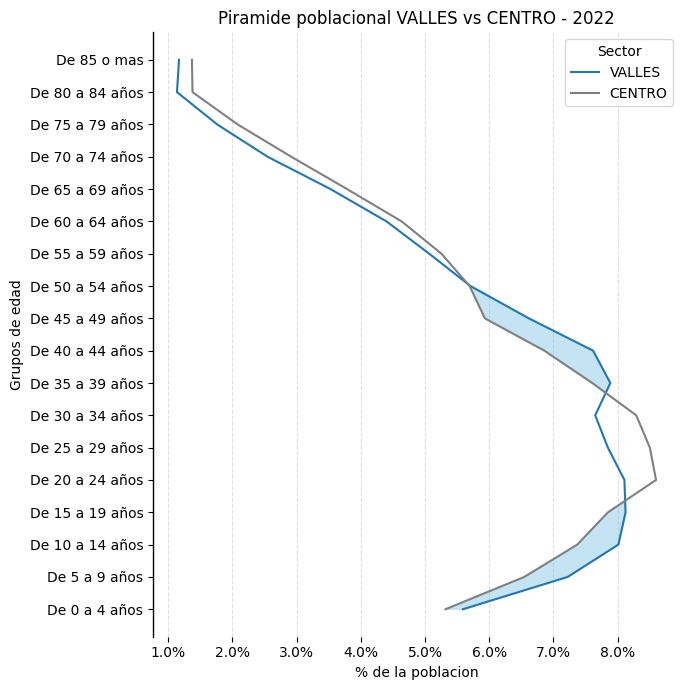

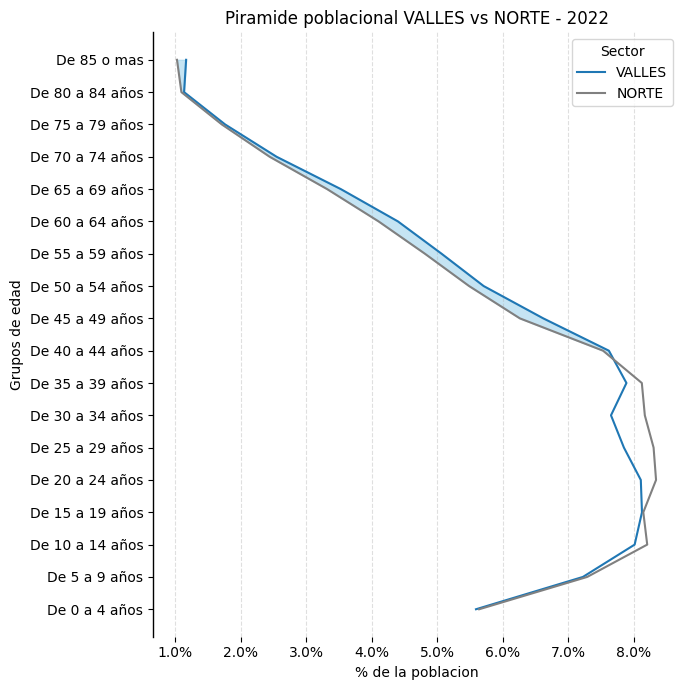

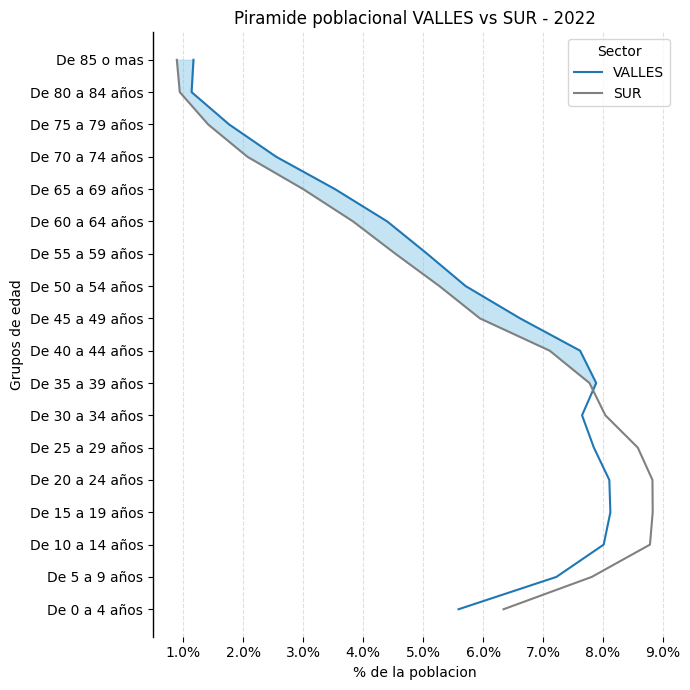

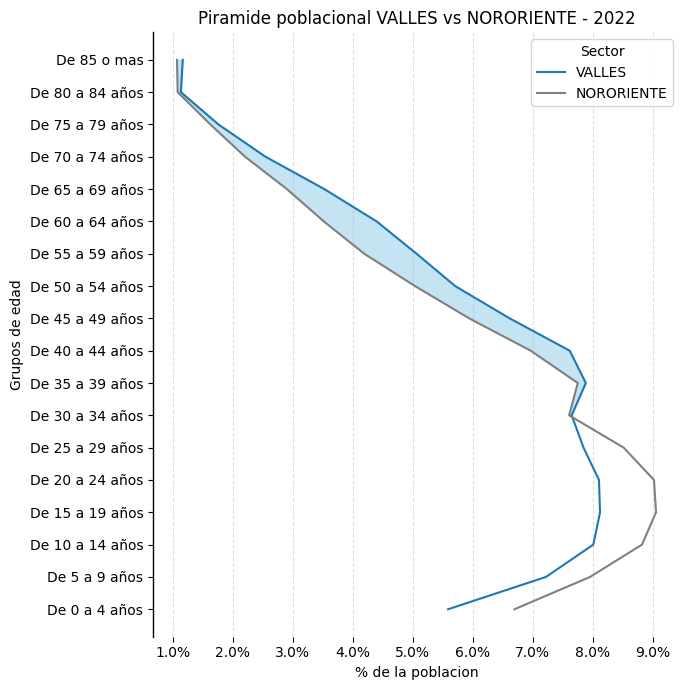

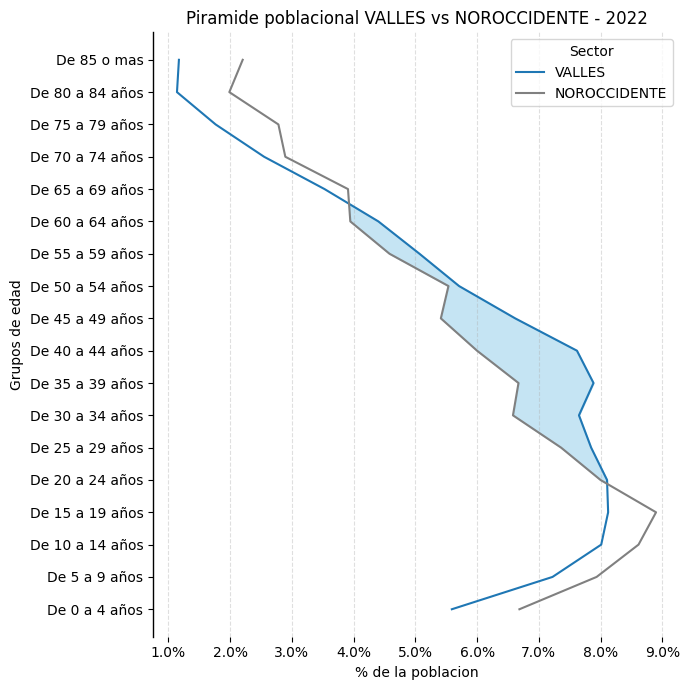

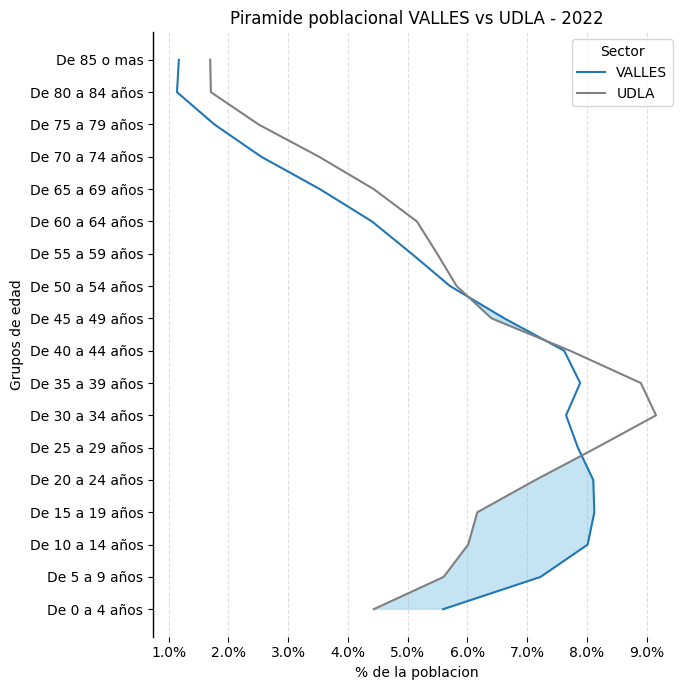

UDLA vs otros: 6 graficos


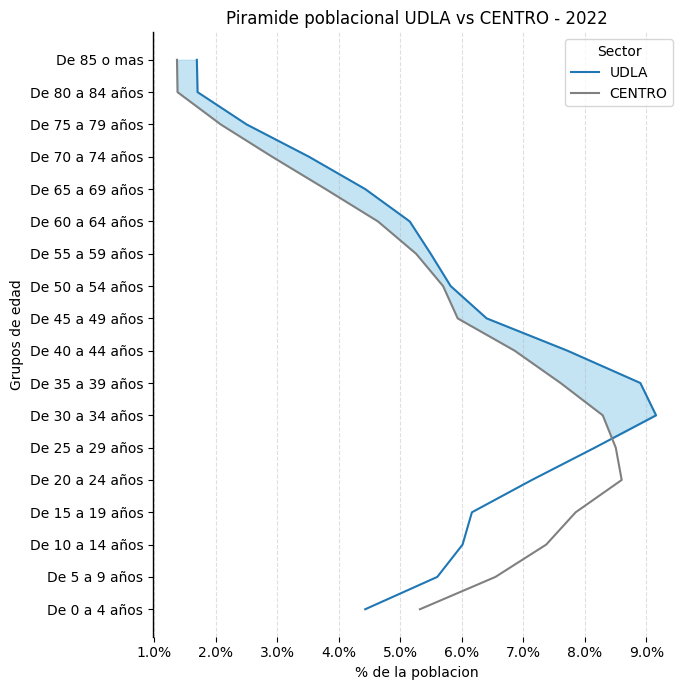

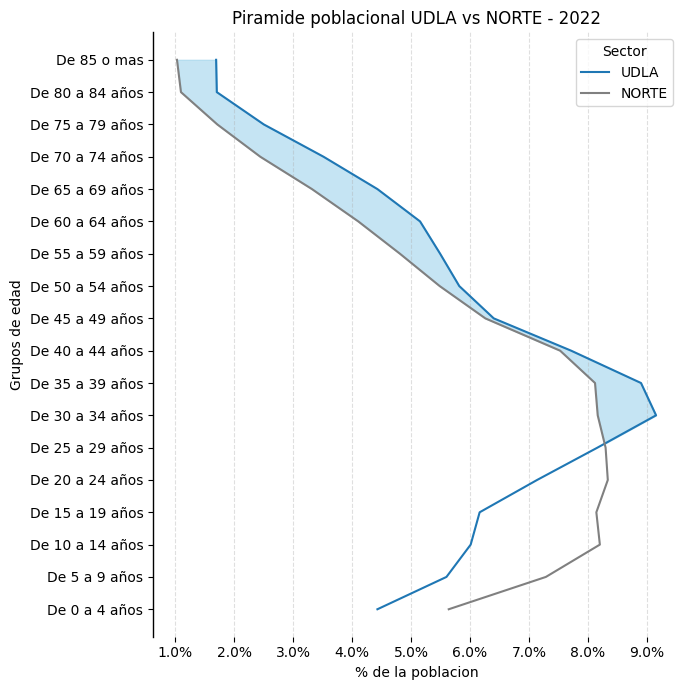

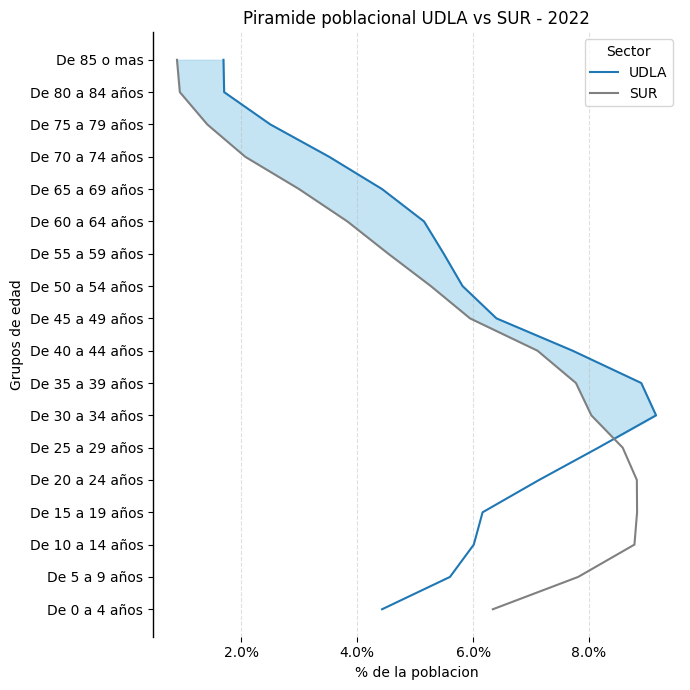

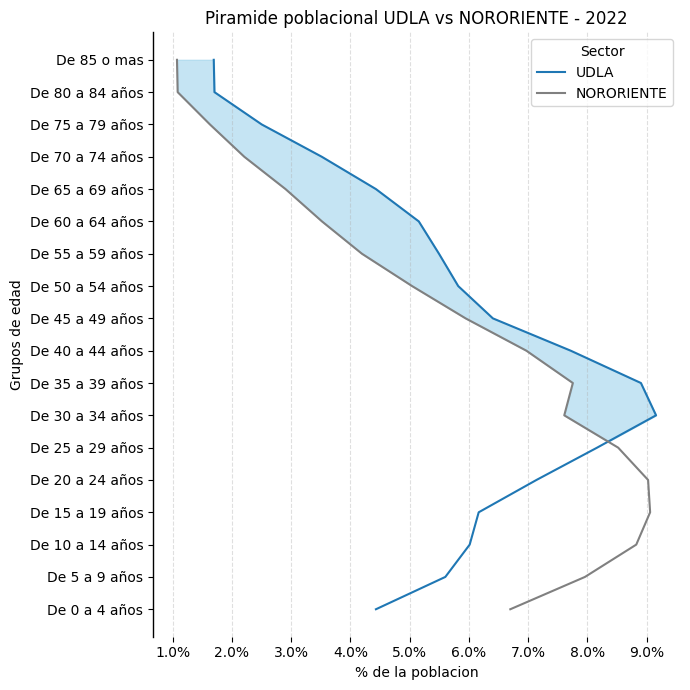

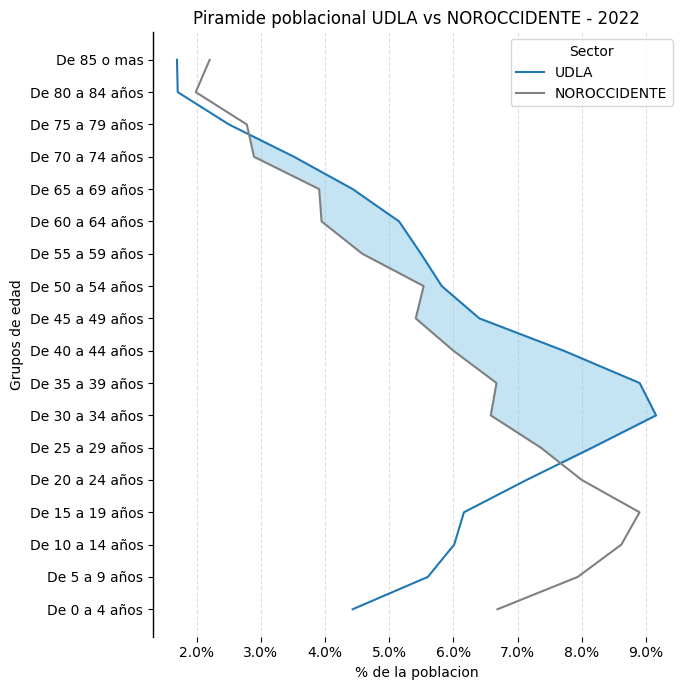

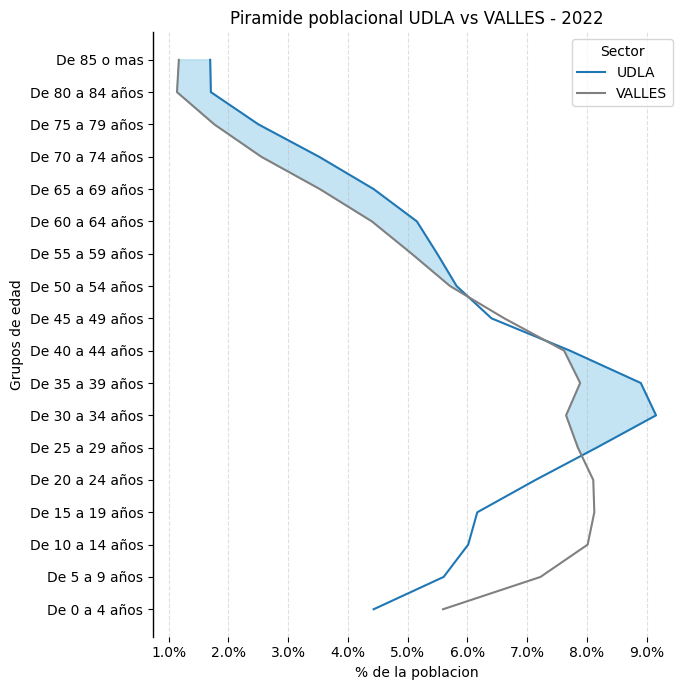

In [2]:
etiquetas_edad = categorias_edad
posiciones = list(range(len(etiquetas_edad)))

def graficar_comparacion(base_sector, otro_sector):
    fig, ax = plt.subplots(figsize=(7, 7))

    base_vals = sector_edad_pct.loc[base_sector, columnas_edad].values
    otro_vals = sector_edad_pct.loc[otro_sector, columnas_edad].values

    ax.plot(base_vals, posiciones, label=base_sector)
    ax.plot(otro_vals, posiciones, label=otro_sector, color="#808080")
    ax.fill_betweenx(
        posiciones,
        base_vals,
        otro_vals,
        where=(base_vals > otro_vals),
        interpolate=True,
        color="#9fd3eb",
        alpha=0.6,
    )

    ax.set_yticks(posiciones)
    ax.set_yticklabels(etiquetas_edad)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_xlabel("% de la poblacion")
    ax.set_ylabel("Grupos de edad")
    ax.set_title(f"Piramide poblacional {base_sector} vs {otro_sector} - 2022")
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    ax.legend(title="Sector")
    plt.tight_layout()
    plt.show()

otros_para_valles = [s for s in sectores_disponibles if s != "VALLES"]
otros_para_udla = [s for s in sectores_disponibles if s != "UDLA"]

print(f"VALLES vs otros: {len(otros_para_valles)} graficos")
for sector in otros_para_valles:
    graficar_comparacion("VALLES", sector)

print(f"UDLA vs otros: {len(otros_para_udla)} graficos")
for sector in otros_para_udla:
    graficar_comparacion("UDLA", sector)
